*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com) and Vahid Mirjalili, Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 16 - Modeling Sequential Data Using Recurrent Neural Networks



Note that the optional watermark extension is a small IPython notebook plugin that is being used to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -v -p numpy,scipy,pyprind,tensorflow

Sebastian Raschka & Vahid Mirjalili 
last updated: 2017-08-27 

CPython 3.6.1
IPython 6.1.0

numpy 1.12.1
scipy 0.19.1
pyprind 2.11.1
tensorflow 1.3.0


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

- [Introducing sequential data](#Introducing-sequential-data)
  - [Modeling sequential data: Order matters](#Modeling-sequential-data:-Order-matters)
  - [Understanding the different categories of sequence modeling](#Understanding-the-different-categories-of-sequence-modeling)
- [Recurrent neural networks for modeling sequences](#Recurrent-neural-networks-for-modeling-sequences)
  - [Understanding the structure and flow of a recurrent neural network 
](#Understanding-the-structure-and-flow-of-a-recurrent-neural-network)
  - [Computing activations in an RNN](#Computing-activations-in-an-RNN)
  - [The challenges of learning long-range interactions](#The-challenges-of-learning-long-range-interactions)
  - [Long short-term memory units](#Long-short-term-memory-units)
- [Implementing a multilayer RNN for sequence modeling in TensorFlow](#Implementing-a-multilayer-RNN-for-sequence-modeling-in-TensorFlow)
  - [Performing sentiment analysis of IMDb movie reviews using multilayer RNNs](#Performing-sentiment-analysis-of-IMDb-movie-reviews-using-multilayer-RNNs)
    - [Preparing the data](#Preparing-the-data)
    - [Embedding](#Embedding)
    - [Building the RNN model](#Building-the-RNN-model)
      - [Step 1: Defining multilayer RNN cells](#Step-1:-Defining-multilayer-RNN-cells)
      - [Step 2: Defining the initial states for the RNN cells](#Step-2:-Defining-the-initial-states-for-the-RNN-cells)
      - [Step 3: Creating the recurrent neural network using the RNN cells and their states](#Step-3:-Creating-the-recurrent-neural-network-using-the-RNN-cells-and-their-states)
  - [Example application: character-level language modeling](#Example-application:-character-level-language-modeling)
    - [Preparing the data](#Preparing-the-data)
    - [Building the character-level RNN model](#Building-the-character-level-RNN-model)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

In [ ]:
import gzip


with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

# Introducing sequential data 

## Modeling sequential data: Order matters

## Representing sequences

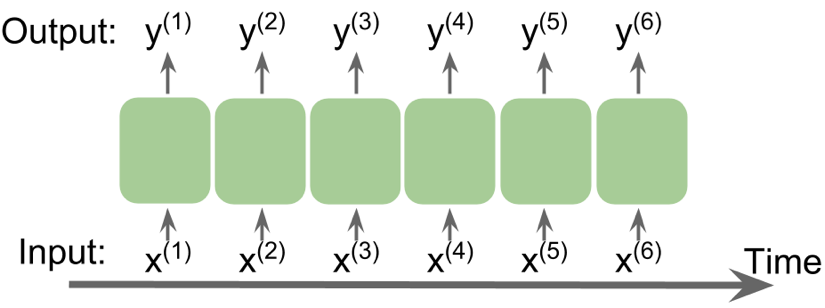

In [3]:
Image(filename='images/16_01.png', width=600) 

## Understanding the different categories of sequence modeling

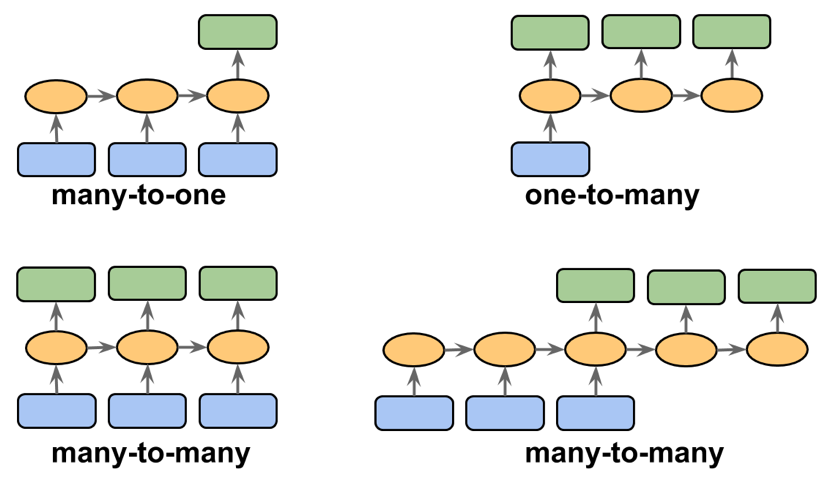

In [4]:
Image(filename='images/16_02.png', width=600) 

# Recurrent neural networks for modeling sequences

## Understanding the structure and flow of a recurrent neural network 

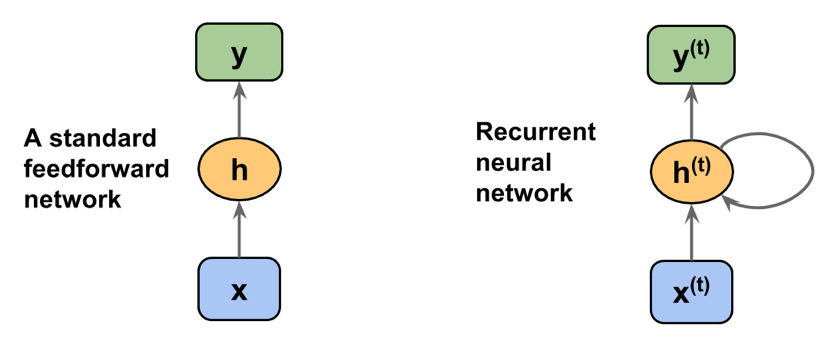

In [5]:
Image(filename='images/16_03.png', width=600) 

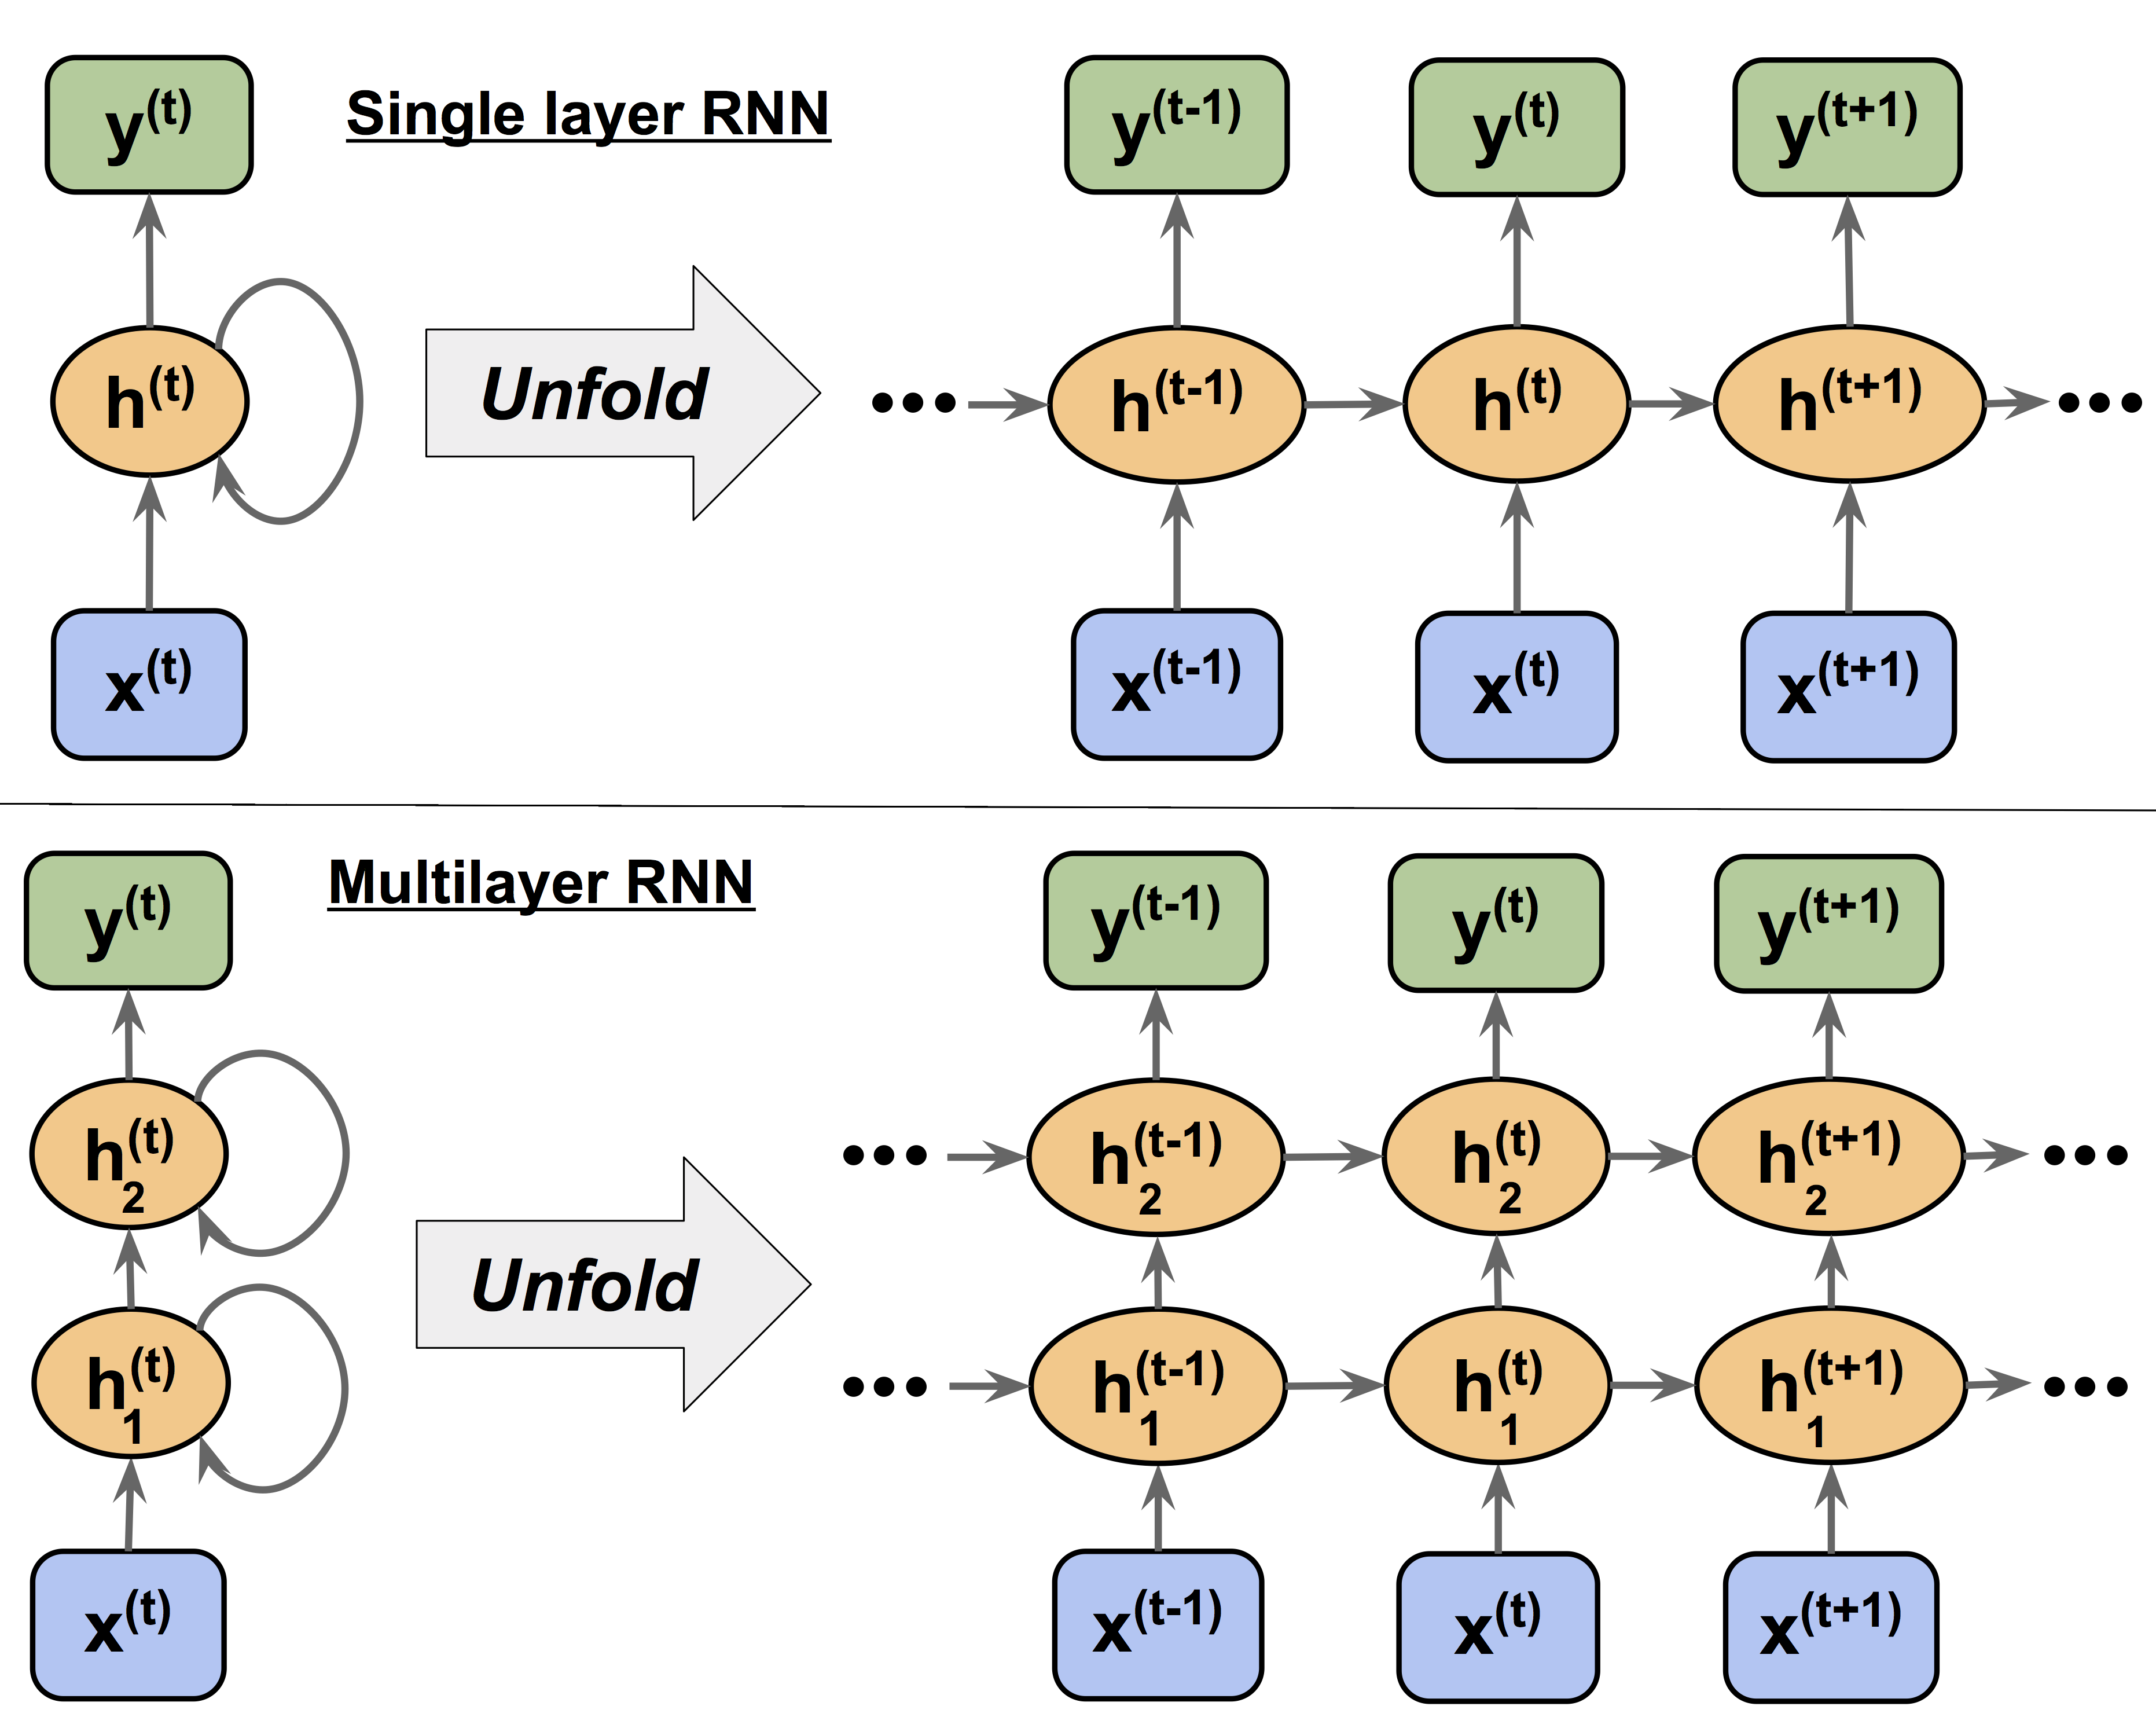

In [6]:
Image(filename='images/16_04.png', width=600) 

## Computing activations in an RNN

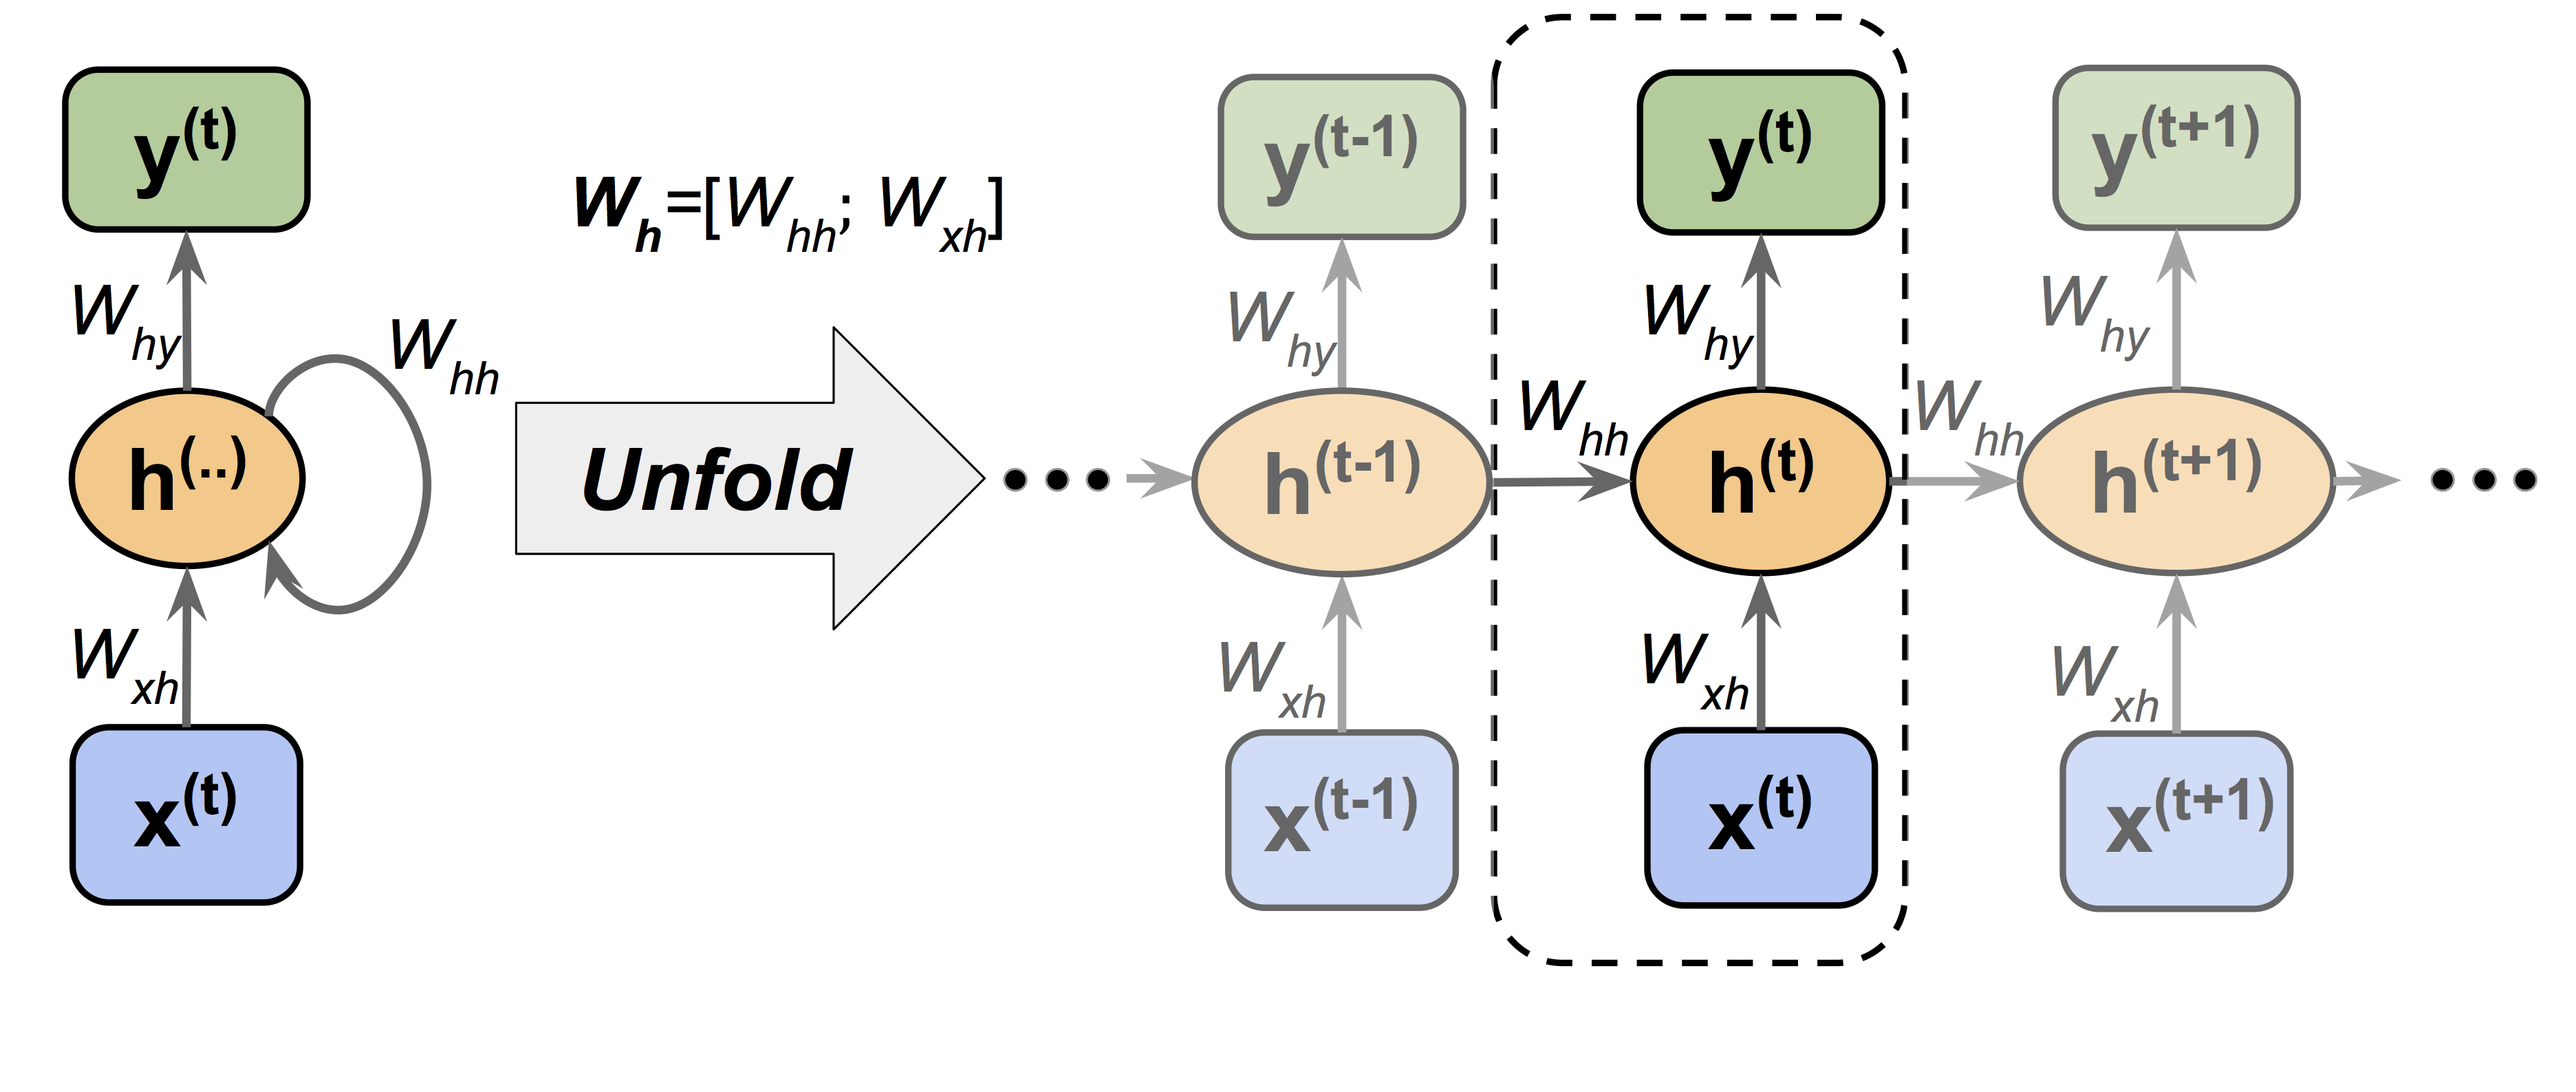

In [7]:
Image(filename='images/16_05.png', width=600) 

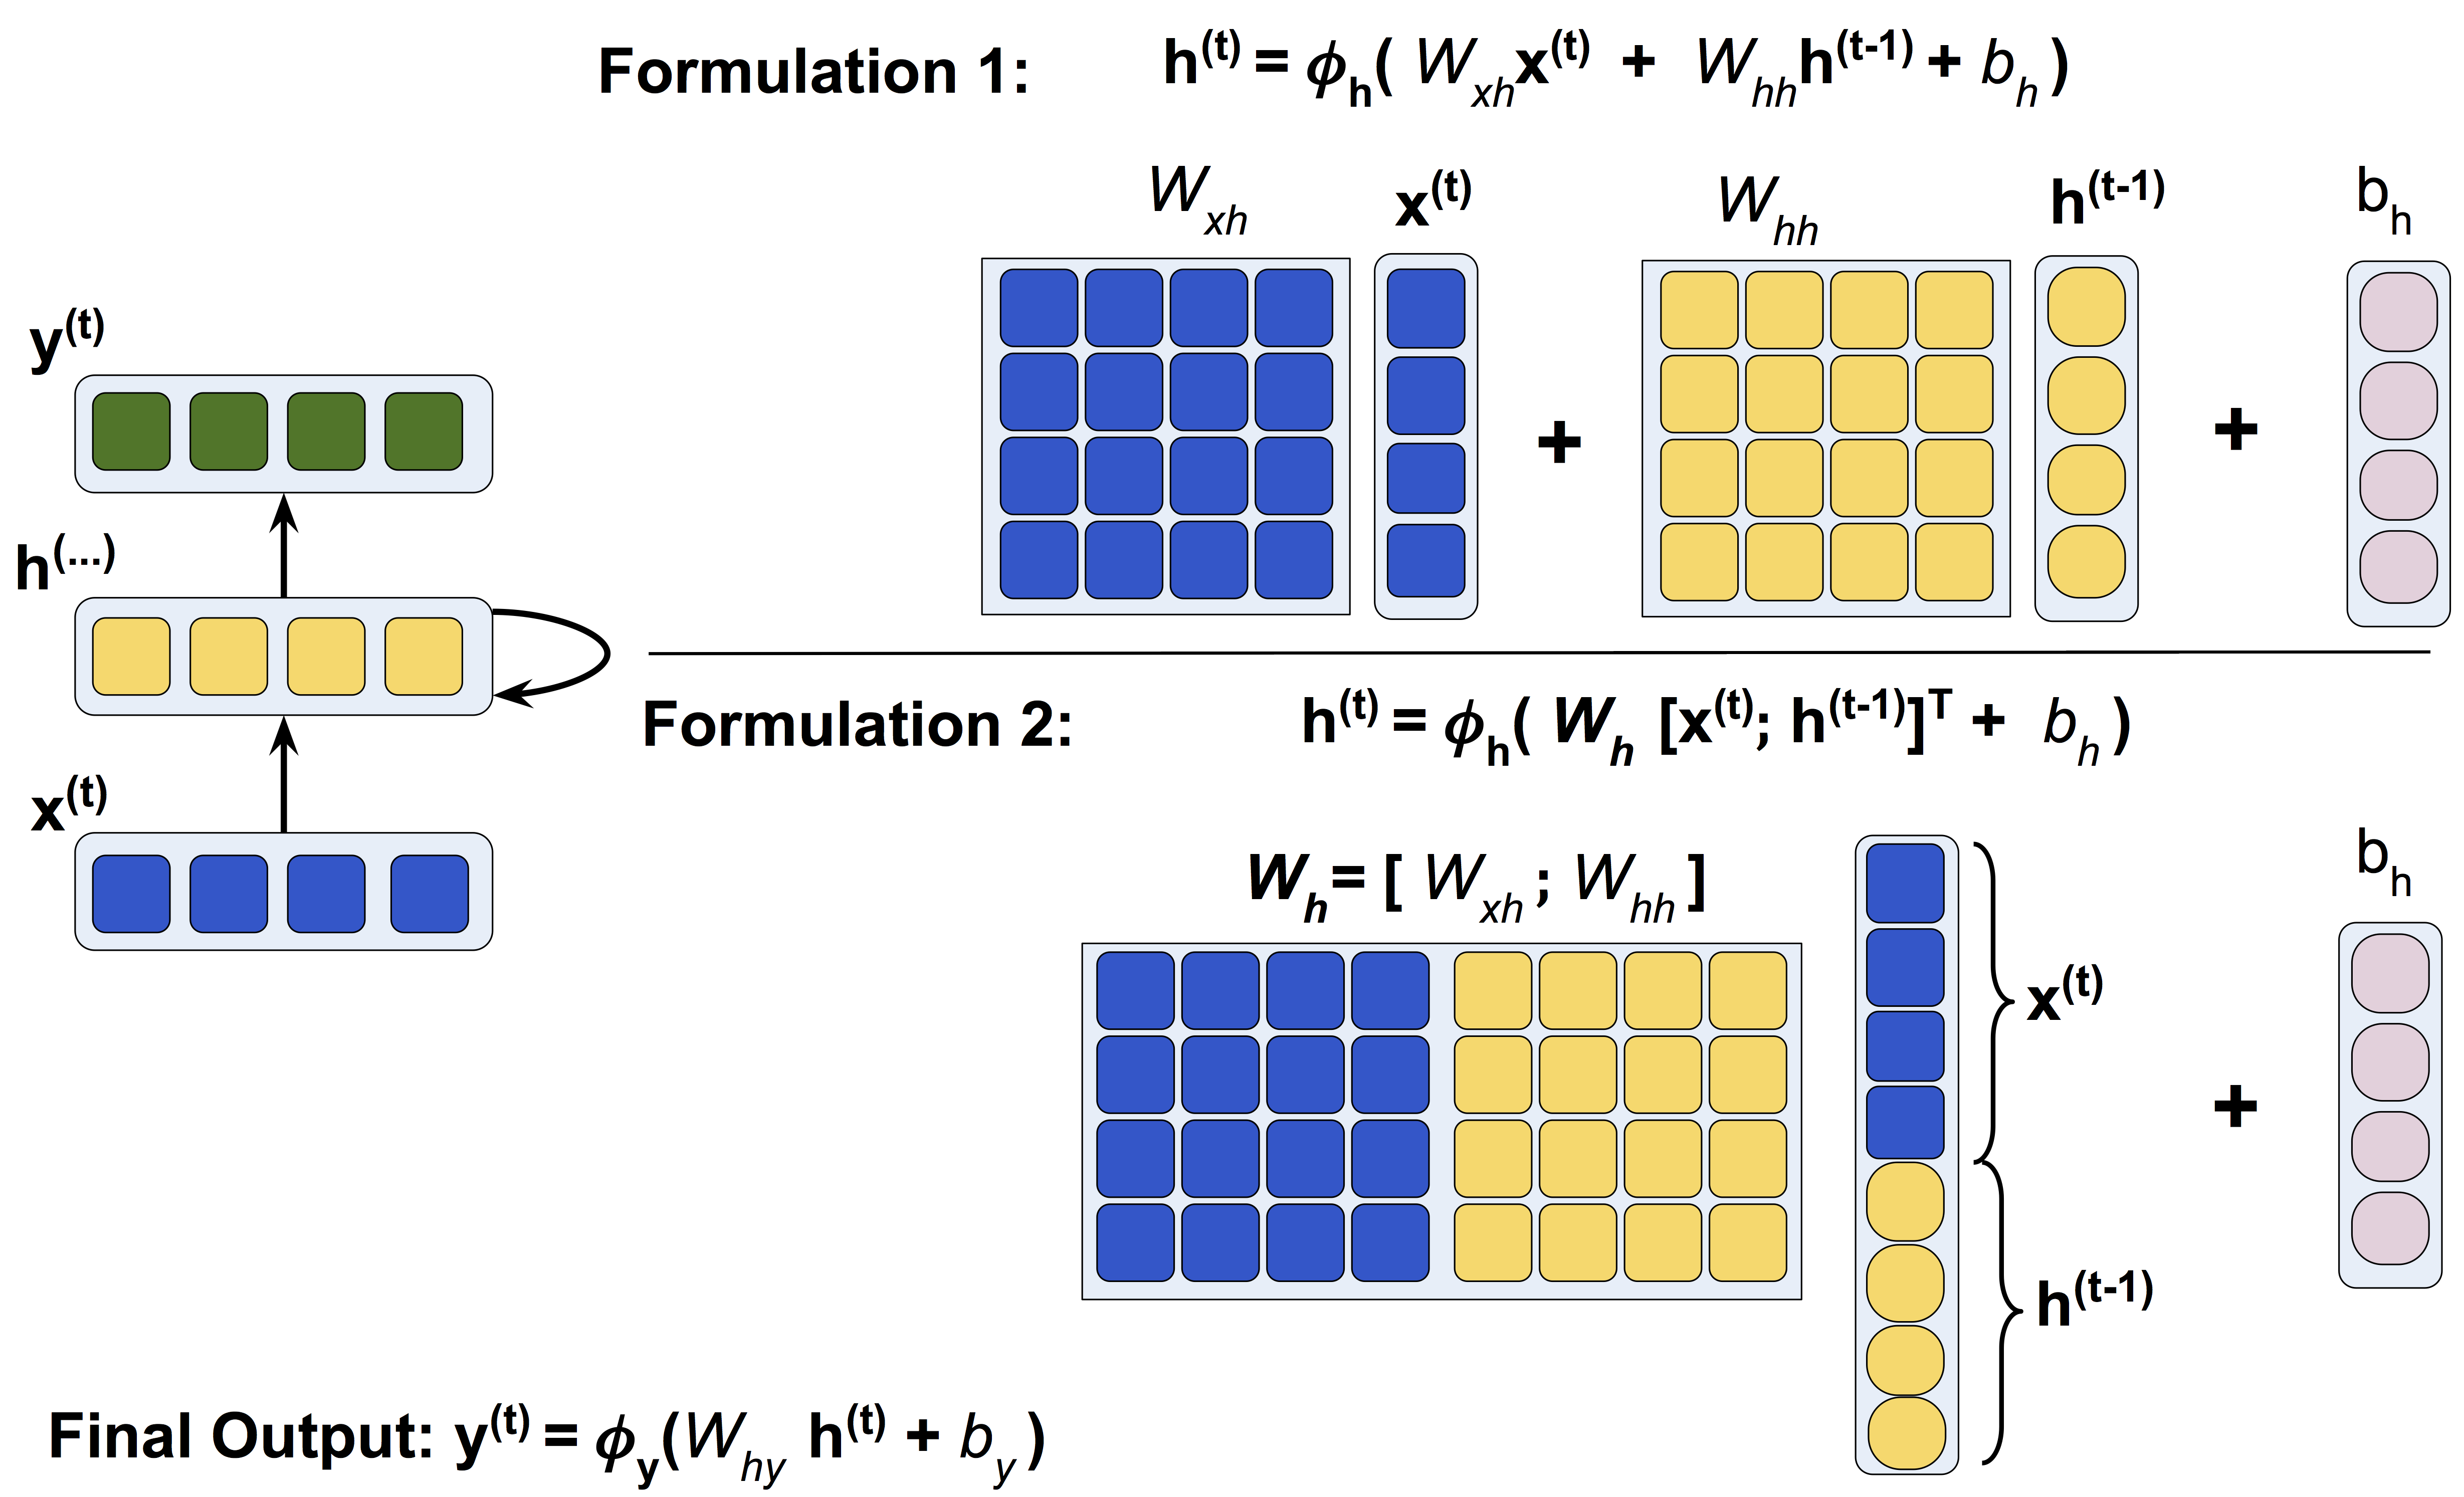

In [8]:
Image(filename='images/16_06.png', width=600) 

## The challenges of learning long-range interactions

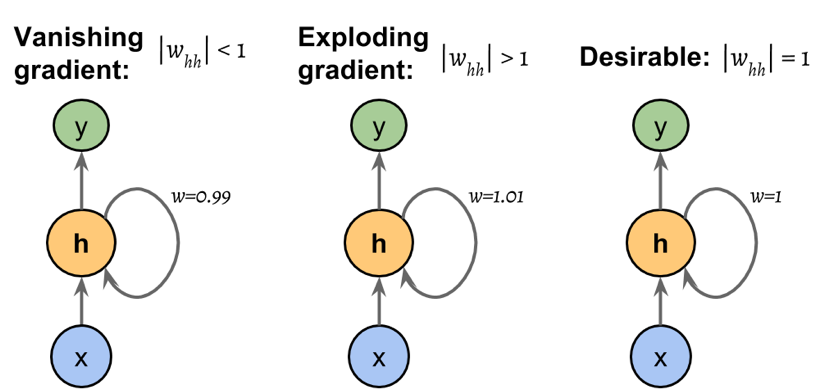

In [9]:
Image(filename='images/16_07.png', width=600) 

## Long short-term memory units

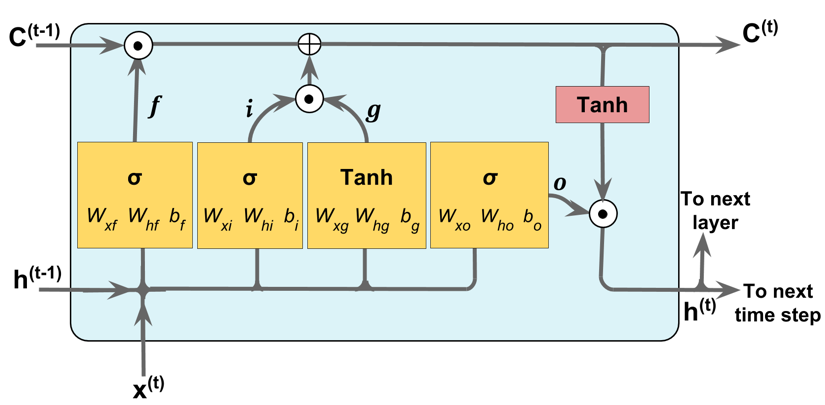

In [10]:
Image(filename='images/16_08.png', width=600) 

# Implementing a multilayer RNN for sequence modeling in TensorFlow

## Performing sentiment analysis of IMDb movie reviews using multilayer RNNs

### Preparing the data

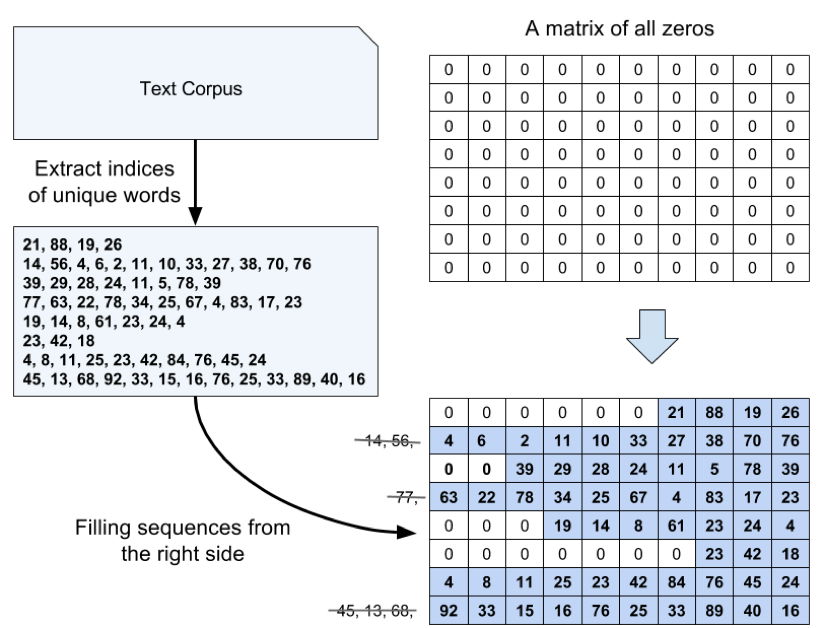

In [11]:
Image(filename='images/16_09.png', width=600) 

In [1]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np


df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.head(3))

                                              review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0


In [ ]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

import os


if 'TRAVIS' in os.environ:
    df = pd.read_csv('movie_data.csv', encoding='utf-8', nrows=500)

In [2]:
## Preprocessing the data:
## Separate words and 
## count each word's occurrence


from collections import Counter


counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                       title='Counting words occurences')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

Counting words occurences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:19


In [3]:
## Create a mapping:
## Map each unique word to an integer

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}


mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                       title='Map reviews to ints')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

Map reviews to ints


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [4]:
## Define fixed-length sequences:
## Use the last 200 elements of each sequence
## if sequence length < 200: left-pad with zeros

sequence_length = 200  ## sequence length (or T in our formulas)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)
for i, row in enumerate(mapped_reviews):
    sequences[i, -len(row):] = np.array(row)[-sequence_length:]

X_train = sequences[:25000, :]
y_train = df.loc[:25000, 'sentiment'].values
X_test = sequences[25000:, :]
y_test = df.loc[25000:, 'sentiment'].values


np.random.seed(123) # for reproducibility

## Function to generate minibatches:
def create_batch_generator(x, y=None, batch_size=64):
    n_batches = len(x)//batch_size
    x= x[:n_batches*batch_size]
    if y is not None:
        y = y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        if y is not None:
            yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            yield x[ii:ii+batch_size]

In [ ]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

if 'TRAVIS' in os.environ:
    X_train = sequences[:250, :]
    y_train = df.loc[:250, 'sentiment'].values
    X_test = sequences[250:500, :]
    y_test = df.loc[250:500, 'sentiment'].values

### Embedding

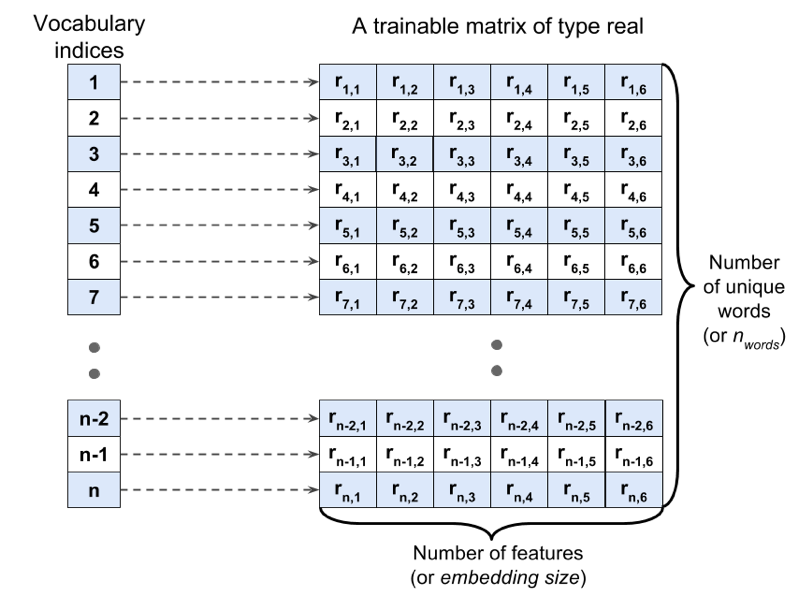

In [12]:
Image(filename='images/16_10.png', width=600) 

### Building the RNN model

In [5]:
import tensorflow as tf


class SentimentRNN(object):
    def __init__(self, n_words, seq_len=200,
                 lstm_size=256, num_layers=1, batch_size=64,
                 learning_rate=0.0001, embed_size=200):
        self.n_words = n_words
        self.seq_len = seq_len
        self.lstm_size = lstm_size   ## number of hidden units
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.embed_size = embed_size

        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)
            self.build()
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()

    def build(self):
        ## Define the placeholders
        tf_x = tf.placeholder(tf.int32,
                    shape=(self.batch_size, self.seq_len),
                    name='tf_x')
        tf_y = tf.placeholder(tf.float32,
                    shape=(self.batch_size),
                    name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32,
                    name='tf_keepprob')
        ## Create the embedding layer
        embedding = tf.Variable(
                    tf.random_uniform(
                        (self.n_words, self.embed_size),
                        minval=-1, maxval=1),
                    name='embedding')
        embed_x = tf.nn.embedding_lookup(
                    embedding, tf_x, 
                    name='embeded_x')

        ## Define LSTM cell and stack them together
        cells = tf.contrib.rnn.MultiRNNCell(
                [tf.contrib.rnn.DropoutWrapper(
                   tf.contrib.rnn.BasicLSTMCell(self.lstm_size),
                   output_keep_prob=tf_keepprob)
                 for i in range(self.num_layers)])

        ## Define the initial state:
        self.initial_state = cells.zero_state(
                 self.batch_size, tf.float32)
        print('  << initial state >> ', self.initial_state)

        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
                 cells, embed_x,
                 initial_state=self.initial_state)
        ## Note: lstm_outputs shape: 
        ##  [batch_size, max_time, cells.output_size]
        print('\n  << lstm_output   >> ', lstm_outputs)
        print('\n  << final state   >> ', self.final_state)

        ## Apply a FC layer after on top of RNN output:
        logits = tf.layers.dense(
                 inputs=lstm_outputs[:, -1],
                 units=1, activation=None,
                 name='logits')
        
        logits = tf.squeeze(logits, name='logits_squeezed')
        print ('\n  << logits        >> ', logits)
        
        y_proba = tf.nn.sigmoid(logits, name='probabilities')
        predictions = {
            'probabilities': y_proba,
            'labels' : tf.cast(tf.round(y_proba), tf.int32,
                 name='labels')
        }
        print('\n  << predictions   >> ', predictions)

        ## Define the cost function
        cost = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(
                 labels=tf_y, logits=logits),
                 name='cost')
        
        ## Define the optimizer
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.minimize(cost, name='train_op')

    def train(self, X_train, y_train, num_epochs):
        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            iteration = 1
            for epoch in range(num_epochs):
                state = sess.run(self.initial_state)
                
                for batch_x, batch_y in create_batch_generator(
                            X_train, y_train, self.batch_size):
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': 0.5,
                            self.initial_state : state}
                    loss, _, state = sess.run(
                            ['cost:0', 'train_op', 
                             self.final_state],
                            feed_dict=feed)

                    if iteration % 20 == 0:
                        print("Epoch: %d/%d Iteration: %d "
                              "| Train loss: %.5f" % (
                               epoch + 1, num_epochs,
                               iteration, loss))

                    iteration +=1
                if (epoch+1)%10 == 0:
                    self.saver.save(sess,
                        "model/sentiment-%d.ckpt" % epoch)

    def predict(self, X_data, return_proba=False):
        preds = []
        with tf.Session(graph = self.g) as sess:
            self.saver.restore(
                sess, tf.train.latest_checkpoint('model/'))
            test_state = sess.run(self.initial_state)
            for ii, batch_x in enumerate(
                create_batch_generator(
                    X_data, None, batch_size=self.batch_size), 1):
                feed = {'tf_x:0' : batch_x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state : test_state}
                if return_proba:
                    pred, test_state = sess.run(
                        ['probabilities:0', self.final_state],
                        feed_dict=feed)
                else:
                    pred, test_state = sess.run(
                        ['labels:0', self.final_state],
                        feed_dict=feed)
                    
                preds.append(pred)
                
        return np.concatenate(preds)

#### Step 1: Defining multilayer RNN cells

#### Step 2: Defining the initial states for the RNN cells


#### Step 3: Creating the recurrent neural network using the RNN cells and their states



In [6]:
## Train:

n_words = max(list(word_to_int.values())) + 1

rnn = SentimentRNN(n_words=n_words, 
                   seq_len=sequence_length,
                   embed_size=256, 
                   lstm_size=128, 
                   num_layers=1, 
                   batch_size=100, 
                   learning_rate=0.001)


  << initial state >>  (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(100, 128) dtype=float32>),)

  << lstm_output   >>  Tensor("rnn/transpose:0", shape=(100, 200, 128), dtype=float32)

  << final state   >>  (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(100, 128) dtype=float32>),)

  << logits        >>  Tensor("logits_squeezed:0", shape=(100,), dtype=float32)

  << predictions   >>  {'probabilities': <tf.Tensor 'probabilities:0' shape=(100,) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(100,) dtype=int32>}


In [7]:
rnn.train(X_train, y_train, num_epochs=40)

Epoch: 1/40 Iteration: 20 | Train loss: 0.70637
Epoch: 1/40 Iteration: 40 | Train loss: 0.60539
Epoch: 1/40 Iteration: 60 | Train loss: 0.66977
Epoch: 1/40 Iteration: 80 | Train loss: 0.51997
Epoch: 1/40 Iteration: 100 | Train loss: 0.53567
Epoch: 1/40 Iteration: 120 | Train loss: 0.59073
Epoch: 1/40 Iteration: 140 | Train loss: 0.45970
Epoch: 1/40 Iteration: 160 | Train loss: 0.43817
Epoch: 1/40 Iteration: 180 | Train loss: 0.45852
Epoch: 1/40 Iteration: 200 | Train loss: 0.45753
Epoch: 1/40 Iteration: 220 | Train loss: 0.42869
Epoch: 1/40 Iteration: 240 | Train loss: 0.48586
Epoch: 2/40 Iteration: 260 | Train loss: 0.39664
Epoch: 2/40 Iteration: 280 | Train loss: 0.30718
Epoch: 2/40 Iteration: 300 | Train loss: 0.31172
Epoch: 2/40 Iteration: 320 | Train loss: 0.33450
Epoch: 2/40 Iteration: 340 | Train loss: 0.30583
Epoch: 2/40 Iteration: 360 | Train loss: 0.25545
Epoch: 2/40 Iteration: 380 | Train loss: 0.41464
Epoch: 2/40 Iteration: 400 | Train loss: 0.35470
Epoch: 2/40 Iteration: 4

Epoch: 14/40 Iteration: 3300 | Train loss: 0.03658
Epoch: 14/40 Iteration: 3320 | Train loss: 0.00325
Epoch: 14/40 Iteration: 3340 | Train loss: 0.02659
Epoch: 14/40 Iteration: 3360 | Train loss: 0.00215
Epoch: 14/40 Iteration: 3380 | Train loss: 0.03560
Epoch: 14/40 Iteration: 3400 | Train loss: 0.01132
Epoch: 14/40 Iteration: 3420 | Train loss: 0.00520
Epoch: 14/40 Iteration: 3440 | Train loss: 0.11881
Epoch: 14/40 Iteration: 3460 | Train loss: 0.02035
Epoch: 14/40 Iteration: 3480 | Train loss: 0.00424
Epoch: 14/40 Iteration: 3500 | Train loss: 0.00247
Epoch: 15/40 Iteration: 3520 | Train loss: 0.00154
Epoch: 15/40 Iteration: 3540 | Train loss: 0.00591
Epoch: 15/40 Iteration: 3560 | Train loss: 0.00991
Epoch: 15/40 Iteration: 3580 | Train loss: 0.00187
Epoch: 15/40 Iteration: 3600 | Train loss: 0.00148
Epoch: 15/40 Iteration: 3620 | Train loss: 0.06541
Epoch: 15/40 Iteration: 3640 | Train loss: 0.00201
Epoch: 15/40 Iteration: 3660 | Train loss: 0.00137
Epoch: 15/40 Iteration: 3680 | 

Epoch: 27/40 Iteration: 6520 | Train loss: 0.01468
Epoch: 27/40 Iteration: 6540 | Train loss: 0.00284
Epoch: 27/40 Iteration: 6560 | Train loss: 0.00949
Epoch: 27/40 Iteration: 6580 | Train loss: 0.00122
Epoch: 27/40 Iteration: 6600 | Train loss: 0.00600
Epoch: 27/40 Iteration: 6620 | Train loss: 0.00272
Epoch: 27/40 Iteration: 6640 | Train loss: 0.00119
Epoch: 27/40 Iteration: 6660 | Train loss: 0.00820
Epoch: 27/40 Iteration: 6680 | Train loss: 0.02572
Epoch: 27/40 Iteration: 6700 | Train loss: 0.00088
Epoch: 27/40 Iteration: 6720 | Train loss: 0.00447
Epoch: 27/40 Iteration: 6740 | Train loss: 0.00314
Epoch: 28/40 Iteration: 6760 | Train loss: 0.00042
Epoch: 28/40 Iteration: 6780 | Train loss: 0.05133
Epoch: 28/40 Iteration: 6800 | Train loss: 0.00135
Epoch: 28/40 Iteration: 6820 | Train loss: 0.00100
Epoch: 28/40 Iteration: 6840 | Train loss: 0.00062
Epoch: 28/40 Iteration: 6860 | Train loss: 0.00085
Epoch: 28/40 Iteration: 6880 | Train loss: 0.03110
Epoch: 28/40 Iteration: 6900 | 

Epoch: 39/40 Iteration: 9740 | Train loss: 0.00002
Epoch: 40/40 Iteration: 9760 | Train loss: 0.00003
Epoch: 40/40 Iteration: 9780 | Train loss: 0.00005
Epoch: 40/40 Iteration: 9800 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9820 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9840 | Train loss: 0.00034
Epoch: 40/40 Iteration: 9860 | Train loss: 0.00003
Epoch: 40/40 Iteration: 9880 | Train loss: 0.00002
Epoch: 40/40 Iteration: 9900 | Train loss: 0.00008
Epoch: 40/40 Iteration: 9920 | Train loss: 0.00004
Epoch: 40/40 Iteration: 9940 | Train loss: 0.00005
Epoch: 40/40 Iteration: 9960 | Train loss: 0.00000
Epoch: 40/40 Iteration: 9980 | Train loss: 0.00000
Epoch: 40/40 Iteration: 10000 | Train loss: 0.00001


In [ ]:
## Test: 
preds = rnn.predict(X_test)
y_true = y_test[:len(preds)]
print('Test Acc.: %.3f' % (
      np.sum(preds == y_true) / len(y_true)))

INFO:tensorflow:Restoring parameters from model/sentiment-39.ckpt
Test Acc.: 0.860


In [ ]:
## Get probabilities:
proba = rnn.predict(X_test, return_proba=True)

INFO:tensorflow:Restoring parameters from model/sentiment-39.ckpt


## Example application: character-level language modeling

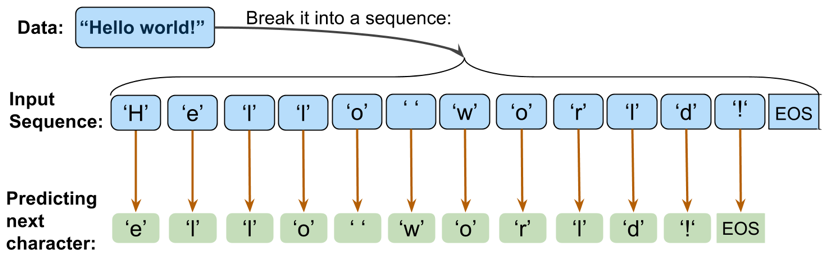

In [13]:
Image(filename='images/16_11.png', width=600) 

### Preparing the data


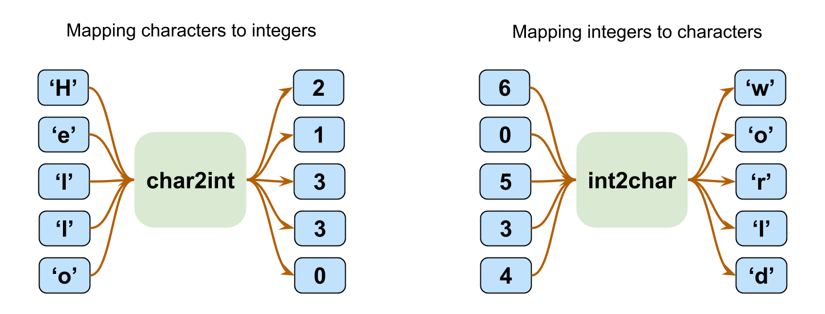

In [14]:
Image(filename='images/16_12.png', width=600) 

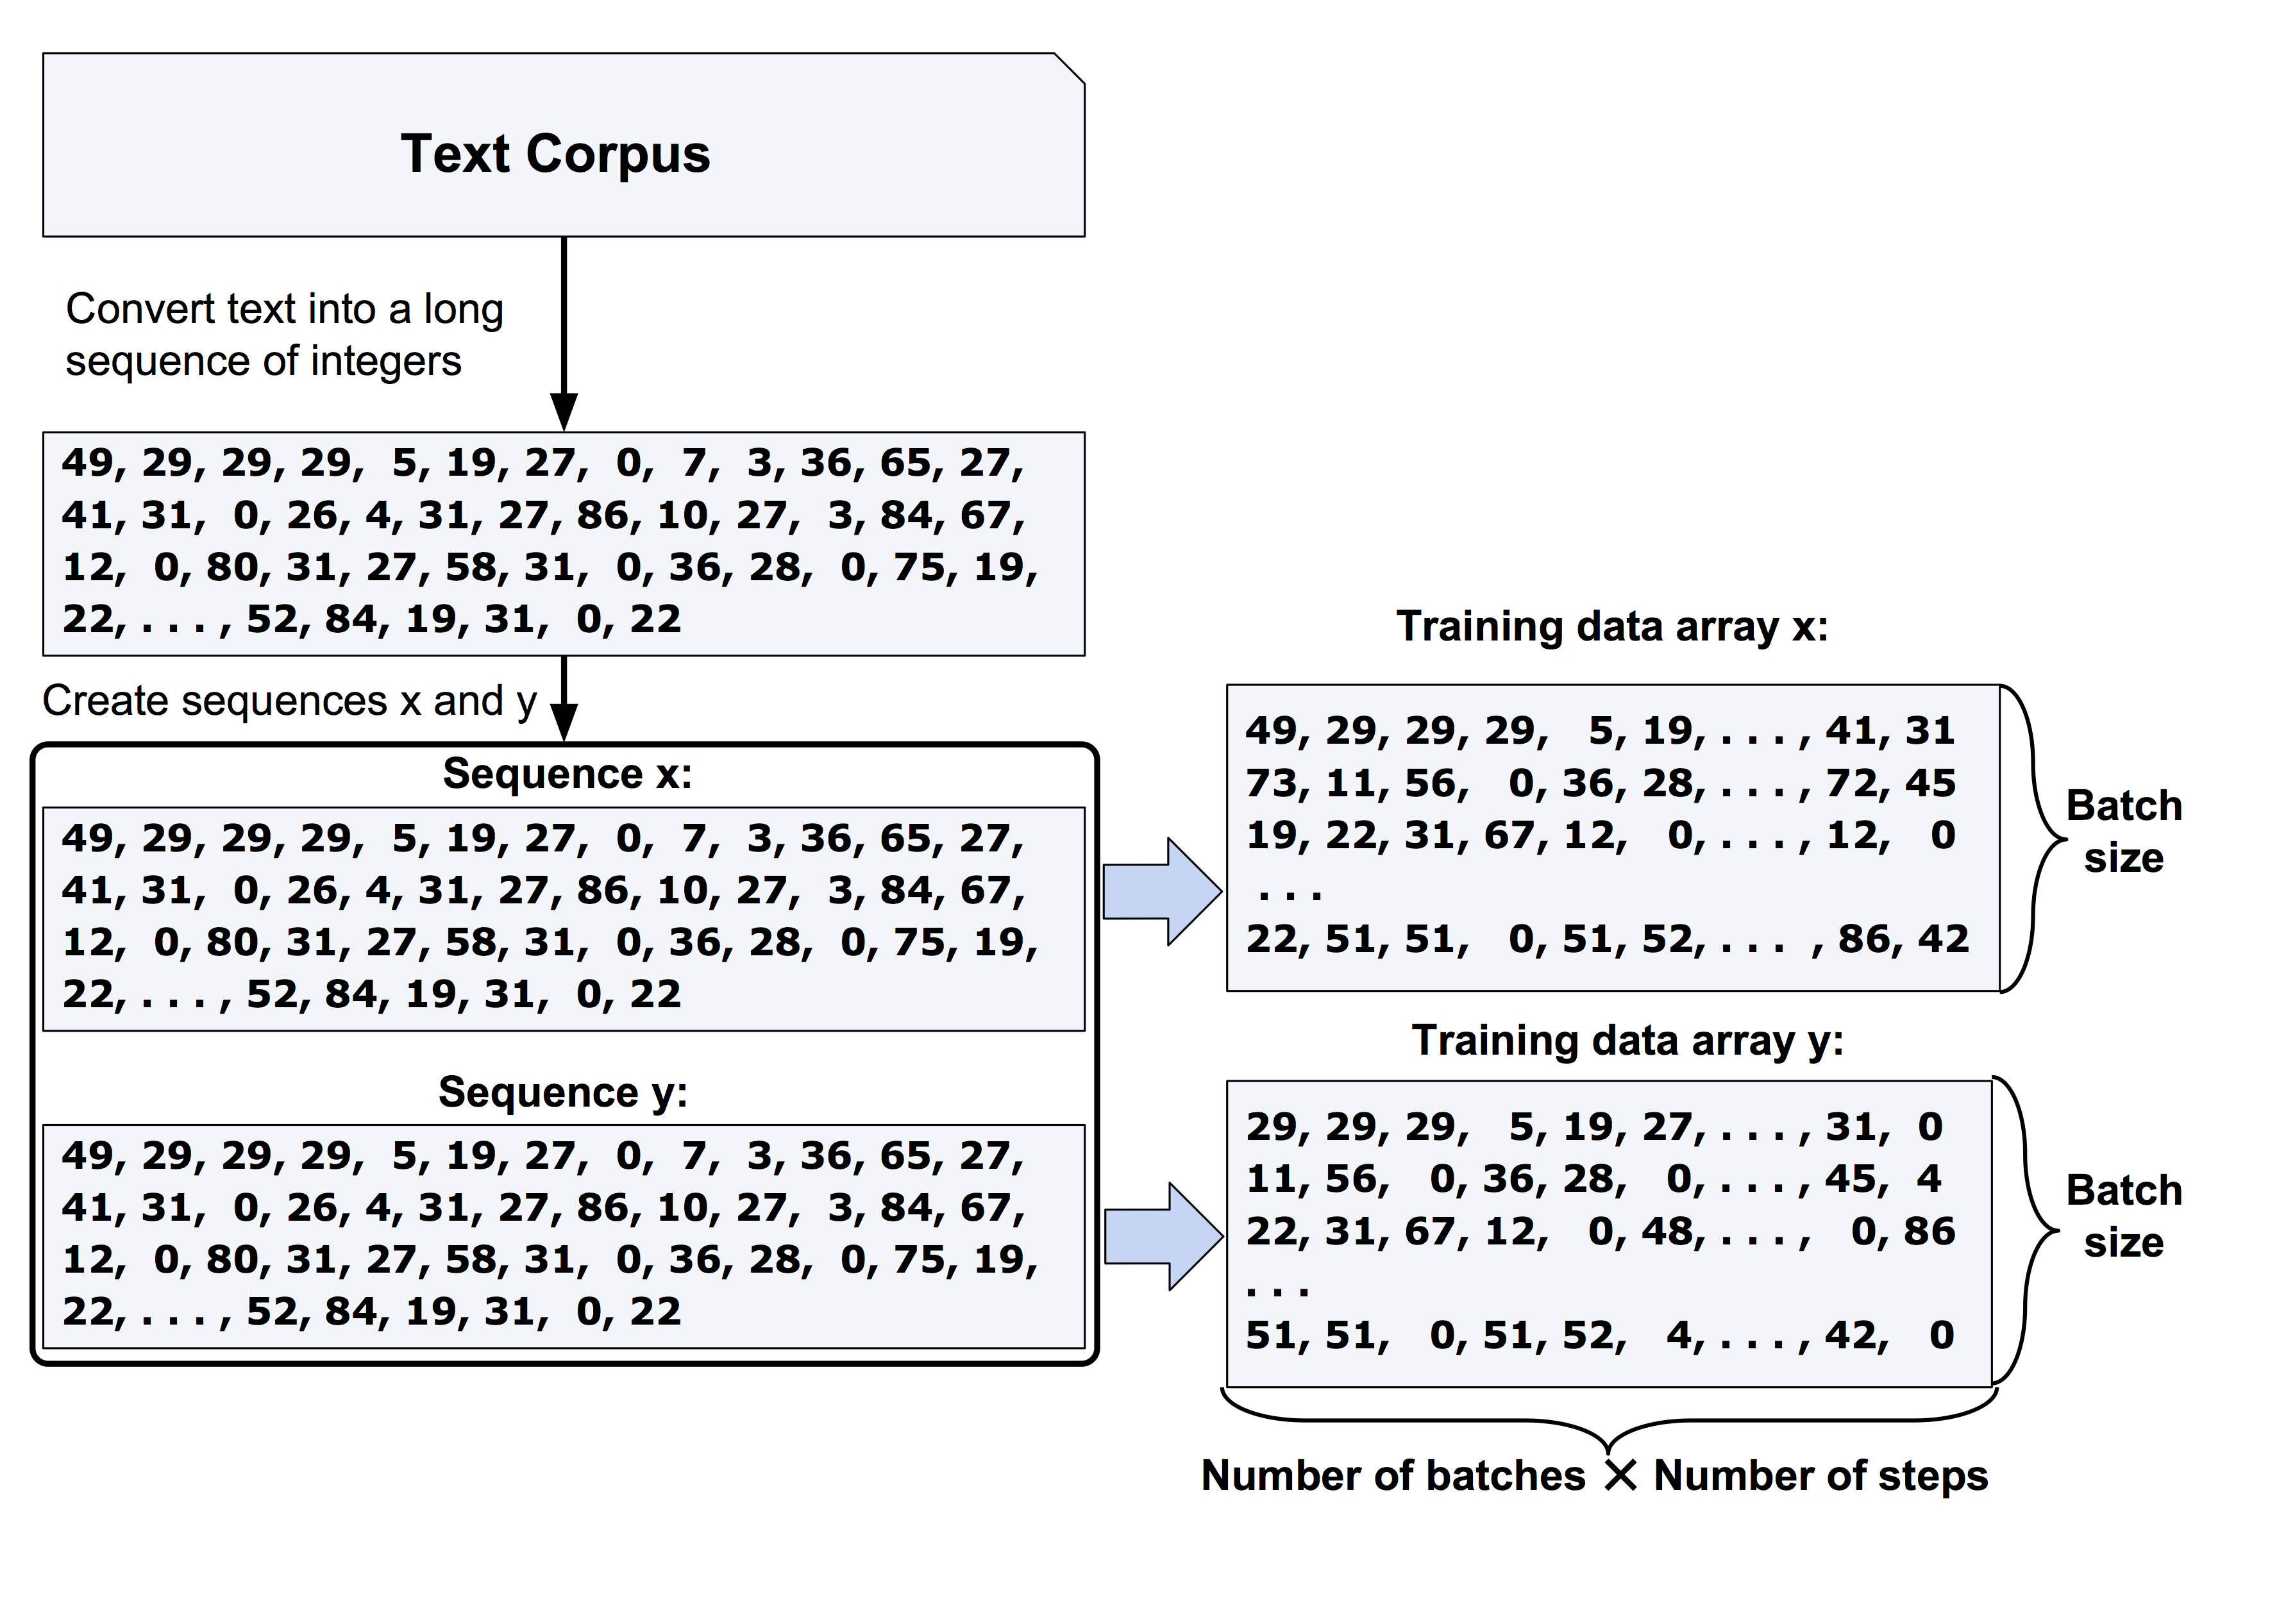

In [15]:
Image(filename='images/16_13.png', width=600) 

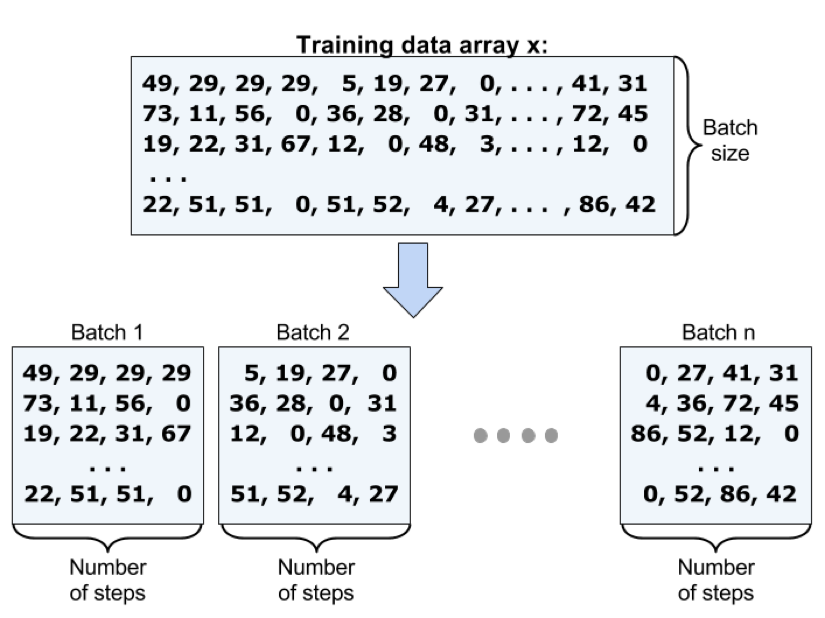

In [16]:
Image(filename='images/16_14.png', width=600) 

In [1]:
import numpy as np


## Reading and processing text
with open('pg2265.txt', 'r', encoding='utf-8') as f: 
    text=f.read()

text = text[15858:]
chars = set(text)
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], 
                     dtype=np.int32)

In [ ]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

if 'TRAVIS' in os.environ:
    text = text[:1000]
    chars = set(text)
    char2int = {ch:i for i,ch in enumerate(chars)}
    int2char = dict(enumerate(chars))
    text_ints = np.array([char2int[ch] for ch in text], 
                         dtype=np.int32)

In [2]:
def reshape_data(sequence, batch_size, num_steps):
    tot_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / tot_batch_length)
    if num_batches*tot_batch_length + 1 > len(sequence):
        num_batches = num_batches - 1
    ## Truncate the sequence at the end to get rid of 
    ## remaining charcaters that do not make a full batch
    x = sequence[0 : num_batches*tot_batch_length]
    y = sequence[1 : num_batches*tot_batch_length + 1]
    ## Split x & y into a list batches of sequences: 
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    ## Stack the batches together
    ## batch_size x tot_batch_length
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x, y

## Testing:
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :50]))

(64, 2540)
[ 8  5 41  2  8 39 19 57 41 55]
[ 5 41  2  8 39 19 57 41 55 47]
The Tragedie of Hamlet

Actus Primus. Scoena Prima


In [3]:
np.random.seed(123)

def create_batch_generator(data_x, data_y, num_steps):
    batch_size, tot_batch_length = data_x.shape    
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps: (b+1)*num_steps], 
               data_y[:, b*num_steps: (b+1)*num_steps])
        
bgen = create_batch_generator(train_x[:,:100], train_y[:,:100], 15)
for b in bgen:
    print(b[0].shape, b[1].shape, end='  ')
    print(''.join(int2char[i] for i in b[0][0,:]).replace('\n', '*'), '    ',
          ''.join(int2char[i] for i in b[1][0,:]).replace('\n', '*'))

(64, 15) (64, 15)  The Tragedie of      he Tragedie of 
(64, 15) (64, 15)   Hamlet**Actus       Hamlet**Actus P
(64, 15) (64, 15)  Primus. Scoena       rimus. Scoena P
(64, 15) (64, 15)  Prima.**Enter B      rima.**Enter Ba
(64, 15) (64, 15)  arnardo and Fra      rnardo and Fran
(64, 15) (64, 15)  ncisco two Cent      cisco two Centi


### Building the character-level RNN model

In [4]:
import tensorflow as tf
import os

class CharRNN(object):
    def __init__(self, num_classes, batch_size=64, 
                 num_steps=100, lstm_size=128, 
                 num_layers=1, learning_rate=0.001, 
                 keep_prob=0.5, grad_clip=5, 
                 sampling=False):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.grad_clip = grad_clip
        
        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)

            self.build(sampling=sampling)
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()
            
    def build(self, sampling):
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size = self.batch_size
            num_steps = self.num_steps

        tf_x = tf.placeholder(tf.int32, 
                              shape=[batch_size, num_steps], 
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[batch_size, num_steps], 
                              name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32, 
                              name='tf_keepprob')

        # One-hot encoding:
        x_onehot = tf.one_hot(tf_x, depth=self.num_classes)
        y_onehot = tf.one_hot(tf_y, depth=self.num_classes)

        ### Build the multi-layer RNN cells
        cells = tf.contrib.rnn.MultiRNNCell(
            [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(self.lstm_size), 
                output_keep_prob=tf_keepprob) 
            for _ in range(self.num_layers)])
        
        ## Define the initial state
        self.initial_state = cells.zero_state(
                    batch_size, tf.float32)

        ## Run each sequence step through the RNN 
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
                    cells, x_onehot, 
                    initial_state=self.initial_state)
        
        print('  << lstm_outputs  >>', lstm_outputs)

        seq_output_reshaped = tf.reshape(
                    lstm_outputs, 
                    shape=[-1, self.lstm_size],
                    name='seq_output_reshaped')

        logits = tf.layers.dense(
                    inputs=seq_output_reshaped, 
                    units=self.num_classes,
                    activation=None,
                    name='logits')

        proba = tf.nn.softmax(
                    logits, 
                    name='probabilities')
        print(proba)

        y_reshaped = tf.reshape(
                    y_onehot, 
                    shape=[-1, self.num_classes],
                    name='y_reshaped')
        cost = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(
                        logits=logits, 
                        labels=y_reshaped),
                    name='cost')

        # Gradient clipping to avoid "exploding gradients"
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
                    tf.gradients(cost, tvars), 
                    self.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.apply_gradients(
                    zip(grads, tvars),
                    name='train_op')
        
    def train(self, train_x, train_y, 
              num_epochs, ckpt_dir='./model/'):
        ## Create the checkpoint directory
        ## if does not exists
        if not os.path.exists(ckpt_dir):
            os.mkdir(ckpt_dir)
            
        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)

            n_batches = int(train_x.shape[1]/self.num_steps)
            iterations = n_batches * num_epochs
            for epoch in range(num_epochs):

                # Train network
                new_state = sess.run(self.initial_state)
                loss = 0
                ## Minibatch generator:
                bgen = create_batch_generator(
                        train_x, train_y, self.num_steps)
                for b, (batch_x, batch_y) in enumerate(bgen, 1):
                    iteration = epoch*n_batches + b
                    
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': self.keep_prob,
                            self.initial_state : new_state}
                    batch_cost, _, new_state = sess.run(
                            ['cost:0', 'train_op', 
                                self.final_state],
                            feed_dict=feed)
                    if iteration % 10 == 0:
                        print('Epoch %d/%d Iteration %d'
                              '| Training loss: %.4f' % (
                              epoch + 1, num_epochs, 
                              iteration, batch_cost))

                ## Save the trained model    
                self.saver.save(
                        sess, os.path.join(
                            ckpt_dir, 'language_modeling.ckpt'))
                              
                              
                
    def sample(self, output_length, 
               ckpt_dir, starter_seq="The "):
        observed_seq = [ch for ch in starter_seq]        
        with tf.Session(graph=self.g) as sess:
            self.saver.restore(
                sess, 
                tf.train.latest_checkpoint(ckpt_dir))
            ## 1: run the model using the starter sequence
            new_state = sess.run(self.initial_state)
            for ch in starter_seq:
                x = np.zeros((1, 1))
                x[0,0] = char2int[ch]
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                proba, new_state = sess.run(
                        ['probabilities:0', self.final_state], 
                        feed_dict=feed)

            ch_id = get_top_char(proba, len(chars))
            observed_seq.append(int2char[ch_id])
            
            ## 2: run the model using the updated observed_seq
            for i in range(output_length):
                x[0,0] = ch_id
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                proba, new_state = sess.run(
                        ['probabilities:0', self.final_state], 
                        feed_dict=feed)

                ch_id = get_top_char(proba, len(chars))
                observed_seq.append(int2char[ch_id])

        return ''.join(observed_seq)


In [5]:
def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

In [6]:
batch_size = 64
num_steps = 100 
train_x, train_y = reshape_data(text_ints, 
                                batch_size, 
                                num_steps)

rnn = CharRNN(num_classes=len(chars), batch_size=batch_size)
rnn.train(train_x, train_y, 
          num_epochs=100,
          ckpt_dir='./model-100/')

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(64, 100, 128), dtype=float32)
Tensor("probabilities:0", shape=(6400, 65), dtype=float32)
Epoch 1/100 Iteration 10| Training loss: 3.7960
Epoch 1/100 Iteration 20| Training loss: 3.3718
Epoch 2/100 Iteration 30| Training loss: 3.2945
Epoch 2/100 Iteration 40| Training loss: 3.2526
Epoch 2/100 Iteration 50| Training loss: 3.2370
Epoch 3/100 Iteration 60| Training loss: 3.2187
Epoch 3/100 Iteration 70| Training loss: 3.1814
Epoch 4/100 Iteration 80| Training loss: 3.1635
Epoch 4/100 Iteration 90| Training loss: 3.1449
Epoch 4/100 Iteration 100| Training loss: 3.1177
Epoch 5/100 Iteration 110| Training loss: 3.1025
Epoch 5/100 Iteration 120| Training loss: 3.0611
Epoch 6/100 Iteration 130| Training loss: 3.0237
Epoch 6/100 Iteration 140| Training loss: 2.9875
Epoch 6/100 Iteration 150| Training loss: 2.9497
Epoch 7/100 Iteration 160| Training loss: 2.9325
Epoch 7/100 Iteration 170| Training loss: 2.8716
Epoch 8/100 Iteration 180| Train

Epoch 65/100 Iteration 1620| Training loss: 1.9805
Epoch 66/100 Iteration 1630| Training loss: 1.9934
Epoch 66/100 Iteration 1640| Training loss: 2.0196
Epoch 66/100 Iteration 1650| Training loss: 1.9443
Epoch 67/100 Iteration 1660| Training loss: 1.9971
Epoch 67/100 Iteration 1670| Training loss: 1.9730
Epoch 68/100 Iteration 1680| Training loss: 1.9897
Epoch 68/100 Iteration 1690| Training loss: 2.0142
Epoch 68/100 Iteration 1700| Training loss: 1.9345
Epoch 69/100 Iteration 1710| Training loss: 1.9896
Epoch 69/100 Iteration 1720| Training loss: 1.9681
Epoch 70/100 Iteration 1730| Training loss: 1.9712
Epoch 70/100 Iteration 1740| Training loss: 1.9971
Epoch 70/100 Iteration 1750| Training loss: 1.9397
Epoch 71/100 Iteration 1760| Training loss: 1.9844
Epoch 71/100 Iteration 1770| Training loss: 1.9534
Epoch 72/100 Iteration 1780| Training loss: 1.9684
Epoch 72/100 Iteration 1790| Training loss: 1.9847
Epoch 72/100 Iteration 1800| Training loss: 1.9189
Epoch 73/100 Iteration 1810| Tr

In [7]:
np.random.seed(123)
rnn = CharRNN(len(chars), sampling=True)

print(rnn.sample(ckpt_dir='./model-100/', 
                 output_length=500))

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(1, 1, 128), dtype=float32)
Tensor("probabilities:0", shape=(1, 65), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model-100/language_modeling.ckpt
The wanderse

   Ham. I woll thenke the Solde and as ither thes will, at a dis tantend
To maness of he and mering and the bus and,
The hiss a fit of ant ort time, and her wind of
A beart of his mine it a faulouthensers

   Hal. Whe that so my Larger,
Thin we selfe to mat tean the hims but
With was sore to beene tiue to ser is betit,
Was thin so a mangers and hill or and asthie

   Hor. This mest the senges of hation thee to hos the herr,
The sacke a my Lort worke. That his she lete,
And whise howers 


In [8]:
## run for 200 epochs
batch_size = 64
num_steps = 100 

rnn = CharRNN(num_classes=len(chars), batch_size=batch_size)
rnn.train(train_x, train_y, 
          num_epochs=200,
          ckpt_dir='./model-200/')

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(64, 100, 128), dtype=float32)
Tensor("probabilities:0", shape=(6400, 65), dtype=float32)
Epoch 1/200 Iteration 10| Training loss: 3.7960
Epoch 1/200 Iteration 20| Training loss: 3.3718
Epoch 2/200 Iteration 30| Training loss: 3.2945
Epoch 2/200 Iteration 40| Training loss: 3.2526
Epoch 2/200 Iteration 50| Training loss: 3.2370
Epoch 3/200 Iteration 60| Training loss: 3.2187
Epoch 3/200 Iteration 70| Training loss: 3.1814
Epoch 4/200 Iteration 80| Training loss: 3.1635
Epoch 4/200 Iteration 90| Training loss: 3.1449
Epoch 4/200 Iteration 100| Training loss: 3.1177
Epoch 5/200 Iteration 110| Training loss: 3.1025
Epoch 5/200 Iteration 120| Training loss: 3.0610
Epoch 6/200 Iteration 130| Training loss: 3.0237
Epoch 6/200 Iteration 140| Training loss: 2.9875
Epoch 6/200 Iteration 150| Training loss: 2.9497
Epoch 7/200 Iteration 160| Training loss: 2.9326
Epoch 7/200 Iteration 170| Training loss: 2.8716
Epoch 8/200 Iteration 180| Train

Epoch 65/200 Iteration 1620| Training loss: 1.9812
Epoch 66/200 Iteration 1630| Training loss: 1.9963
Epoch 66/200 Iteration 1640| Training loss: 2.0218
Epoch 66/200 Iteration 1650| Training loss: 1.9483
Epoch 67/200 Iteration 1660| Training loss: 1.9980
Epoch 67/200 Iteration 1670| Training loss: 1.9735
Epoch 68/200 Iteration 1680| Training loss: 1.9924
Epoch 68/200 Iteration 1690| Training loss: 2.0138
Epoch 68/200 Iteration 1700| Training loss: 1.9341
Epoch 69/200 Iteration 1710| Training loss: 1.9912
Epoch 69/200 Iteration 1720| Training loss: 1.9683
Epoch 70/200 Iteration 1730| Training loss: 1.9711
Epoch 70/200 Iteration 1740| Training loss: 1.9984
Epoch 70/200 Iteration 1750| Training loss: 1.9381
Epoch 71/200 Iteration 1760| Training loss: 1.9833
Epoch 71/200 Iteration 1770| Training loss: 1.9536
Epoch 72/200 Iteration 1780| Training loss: 1.9686
Epoch 72/200 Iteration 1790| Training loss: 1.9859
Epoch 72/200 Iteration 1800| Training loss: 1.9188
Epoch 73/200 Iteration 1810| Tr

Epoch 129/200 Iteration 3220| Training loss: 1.7941
Epoch 130/200 Iteration 3230| Training loss: 1.8009
Epoch 130/200 Iteration 3240| Training loss: 1.8221
Epoch 130/200 Iteration 3250| Training loss: 1.7675
Epoch 131/200 Iteration 3260| Training loss: 1.8025
Epoch 131/200 Iteration 3270| Training loss: 1.8123
Epoch 132/200 Iteration 3280| Training loss: 1.7833
Epoch 132/200 Iteration 3290| Training loss: 1.8212
Epoch 132/200 Iteration 3300| Training loss: 1.7487
Epoch 133/200 Iteration 3310| Training loss: 1.8008
Epoch 133/200 Iteration 3320| Training loss: 1.7916
Epoch 134/200 Iteration 3330| Training loss: 1.7908
Epoch 134/200 Iteration 3340| Training loss: 1.8309
Epoch 134/200 Iteration 3350| Training loss: 1.7554
Epoch 135/200 Iteration 3360| Training loss: 1.8099
Epoch 135/200 Iteration 3370| Training loss: 1.7940
Epoch 136/200 Iteration 3380| Training loss: 1.7932
Epoch 136/200 Iteration 3390| Training loss: 1.8138
Epoch 136/200 Iteration 3400| Training loss: 1.7535
Epoch 137/20

Epoch 192/200 Iteration 4800| Training loss: 1.6511
Epoch 193/200 Iteration 4810| Training loss: 1.7041
Epoch 193/200 Iteration 4820| Training loss: 1.6989
Epoch 194/200 Iteration 4830| Training loss: 1.6972
Epoch 194/200 Iteration 4840| Training loss: 1.7174
Epoch 194/200 Iteration 4850| Training loss: 1.6604
Epoch 195/200 Iteration 4860| Training loss: 1.7063
Epoch 195/200 Iteration 4870| Training loss: 1.6896
Epoch 196/200 Iteration 4880| Training loss: 1.6934
Epoch 196/200 Iteration 4890| Training loss: 1.7224
Epoch 196/200 Iteration 4900| Training loss: 1.6729
Epoch 197/200 Iteration 4910| Training loss: 1.7026
Epoch 197/200 Iteration 4920| Training loss: 1.7030
Epoch 198/200 Iteration 4930| Training loss: 1.6805
Epoch 198/200 Iteration 4940| Training loss: 1.7290
Epoch 198/200 Iteration 4950| Training loss: 1.6533
Epoch 199/200 Iteration 4960| Training loss: 1.7056
Epoch 199/200 Iteration 4970| Training loss: 1.6893
Epoch 200/200 Iteration 4980| Training loss: 1.6851
Epoch 200/20

In [9]:
del rnn

np.random.seed(123)
rnn = CharRNN(len(chars), sampling=True)
print(rnn.sample(ckpt_dir='./model-200/', 
                 output_length=500))

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(1, 1, 128), dtype=float32)
Tensor("probabilities:0", shape=(1, 65), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model-200/language_modeling.ckpt
The drangast and bed thee,
The cainet in all here astensere and are
the pease, and were our Celsestining on this,
That and some somes or so the bestere all,
An isther meene ale out me the Somes

   Ham. And so his werled to my some, that shall
Ans bestie to hous tangert and them and startes,
Who sholl thim to the were, wit out thit?
This mortus in this sentat on his winde,
And say to senfinct with this say in hat,
But is to myere then to the sation: but you doue,
The Conne sticke of her shelletsour h


# Summary